<a href="https://www.kaggle.com/code/aisuko/backpropogation-without-pytorch?scriptVersionId=188671524" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

In this notebook, we defien neural network(mathmatical expression). And it takes input as the data, the weights and the parameters of the neural net mathematical expressions for the forward pass followed by a loss function. And the loss function tries to measure the accuracy of the prediciton. Loss is lower the network is accuracy is higher.

We also backward the loss use backpropagation to get the gradient and then we know how to tune all the parameters to decrease the loss locally.

Then we have to iterate that process many times in what's called the gradient descent.

# Backpropogation

In [1]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True

# perform arithmetic
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# return the element from the tensor with data
print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [2]:
o.item()

0.7071066904050358

# Neural network

Three steps to implement a neural network:

* **Forward a single neuron**
* **Define a layer of neurons**

In [3]:
import random
import math

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data=data
        self.grad=0.0
        self._backward = lambda: None
        self._prev=set(_children)
        self._op=_op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
  
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            
            
# Begin from here
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # formula is w*x+b
        act=sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out=act.tanh()
        return out
    
x=[2.0, 3.0]
# length of input x is 2
n=Neuron(2)
n(x)

Value(data=-0.9867303300157012)

In [4]:
# Define a layer of neurons

class Layer:
    """
    What is the layer of neurons?
    * It's a set of neurons evaluated independently
    """
    def __init__(self, nin, nout):
        """
        nin: input
        nount: the size of(number of neurons) a single layer
        """
        self.neurons=[Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs=[n(x) for n in self.neurons]
        return outs
    
x=[2.0, 3.0]
# input is 2 neurons, the output is 3 neurons
# It is a two dimensional neurons, and we have three of them
n=Layer(2,3)
n(x)

[Value(data=-0.7246252758778711),
 Value(data=-0.2165131291122238),
 Value(data=0.9262284565888494)]

In [5]:
# We want to define a 3 input neurons -> 2 layers of 4-> 1 output unit of a MLP

class MLP:
    def __init__(self, nin, nouts):
        """
        nin: input neurons
        nouts: all the size for the rest layers
        """
        sz = [nin]+nouts
        self.layers=[Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# three inputs
x=[2.0, 3.0, -1.0]
# 3 inputs layers, two 4 layers, one output layer
n =MLP(3, [4,4,1])
n(x)
        

[Value(data=-0.5713838023923478)]

In [6]:
# optimize we return values not a list, like: [Value(data=0.22888237572490946)]
class Layer:
    """
    What is the layer of neurons?
    * It's a set of neurons evaluated independently
    """
    def __init__(self, nin, nout):
        """
        nin: input
        nount: the size of(number of neurons) a single layer
        """
        self.neurons=[Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

class MLP:
    def __init__(self, nin, nouts):
        """
        nin: input neurons
        nouts: all the size for the rest layers
        """
        sz = [nin]+nouts
        self.layers=[Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# three inputs
x=[2.0, 3.0, -1.0]
# 3 inputs layers, two 4 layers, one output layer
n =MLP(3, [4,4,1])
n(x)


Value(data=0.32838323142280856)

# Visualization

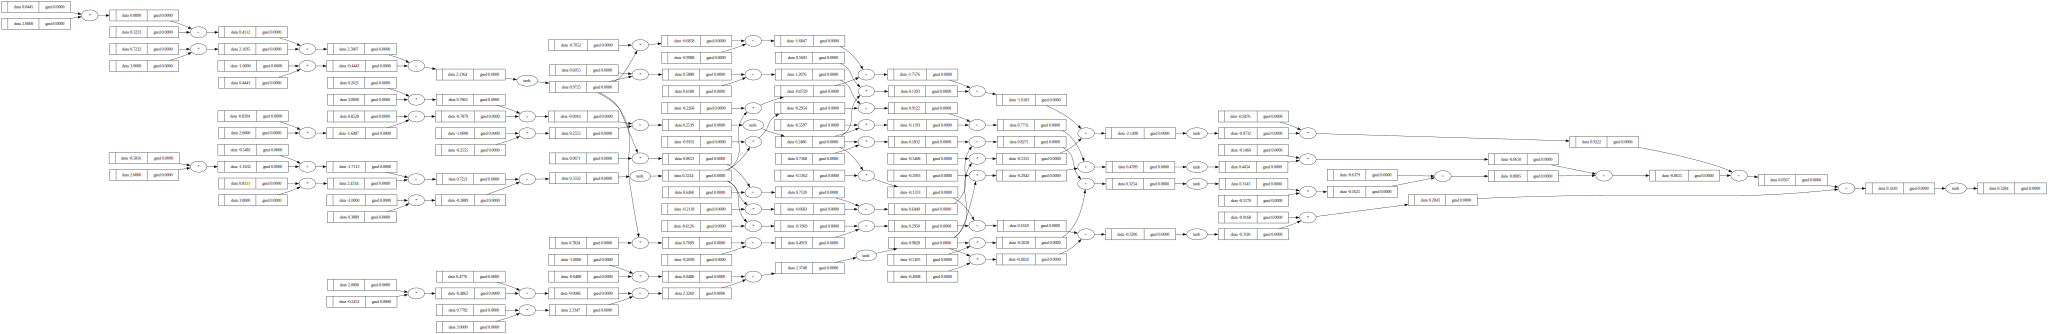

In [7]:
# Chain rule is important. 
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

draw_dot(n(x))

# Define dataset

Our dataset is design for a binary classifier neural net here.

In [8]:
# we have four possible inputs
xs = [
  [2.0, 3.0, -1.0],# -> 1.0
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# four possible labels
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# we preduct ys by using our neural network
# data is the real value we predict, so, we should tune the weights of network
# to make sure to get a better result of prediction.
ypred=[n(x) for x in xs]
ypred

[Value(data=0.32838323142280856),
 Value(data=-0.8159748193177428),
 Value(data=0.291878676852968),
 Value(data=-0.1499726279360212)]

# Loss

We achieve this by calculating a single number that measure the total performance of the neural net. It is the loss.

In this section, we will implement the mean squared error loss.

In [9]:
# Squared error implement
# with squared operation, regardless of whether we are more negative 
# of more positive we always get a positive number

# we need to discard the sign
[(yout-ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=0.45106908383406874),
 Value(data=0.03386526712513739),
 Value(data=1.6689505157073752),
 Value(data=1.3224370450020786)]

# Final loss

The sum of all of these numbers above.

In [10]:
# the final loss
loss=sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.47632191166866)

In [11]:
loss.backward()

In [12]:
n.layers[0].neurons[0].w[0].grad

0.9381149574263957

In [13]:
n.layers[0].neurons[0].w[0].data

0.044485592352417225

# Collecting parameters of NN

We will collect the parameters of NN. We wan to investgate how we use the gradient to influent values.

In [14]:
# Begin from here
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # formula is w*x+b
        act=sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out=act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

# optimize we return values not a list, like: [Value(data=0.22888237572490946)]
class Layer:
    """
    What is the layer of neurons?
    * It's a set of neurons evaluated independently
    """
    def __init__(self, nin, nout):
        """
        nin: input
        nount: the size of(number of neurons) a single layer
        """
        self.neurons=[Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        """
        nin: input neurons
        nouts: all the size for the rest layers
        """
        sz = [nin]+nouts
        self.layers=[Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# three inputs
x=[2.0, 3.0, -1.0]
# 3 inputs layers, two 4 layers, one output layer
n =MLP(3, [4,4,1])
n(x)

Value(data=-0.18416322021597528)

In [15]:
ypred=[n(x) for x in xs]
ypred

[Value(data=-0.18416322021597528),
 Value(data=-0.6143617745176927),
 Value(data=-0.4072013489459239),
 Value(data=-0.3419478747159694)]

In [16]:
loss=sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.703193712211651)

In [17]:
loss.backward()

In [18]:
for p in n.parameters():
    p.data +=-0.1*p.grad

In [19]:
ypred

[Value(data=-0.18416322021597528),
 Value(data=-0.6143617745176927),
 Value(data=-0.4072013489459239),
 Value(data=-0.3419478747159694)]

# Training loop

Let's do a summary for above steps and write all in one training loop function.

In [21]:
# we have four possible inputs
xs = [
  [2.0, 3.0, -1.0],# -> 1.0
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# four possible labels
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# we preduct ys by using our neural network
# data is the real value we predict, so, we should tune the weights of network
# to make sure to get a better result of prediction.
ypred=[n(x) for x in xs]
ypred

for k in range(20):
    # forward pass
    ypred=[n(x) for x in xs]
    loss=sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad=0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data+=-0.05*p.grad
    print(k ,loss.data)
    

0 0.10280310089588623
1 0.08671269517378799
2 0.07454665504395971
3 0.06510069639271548
4 0.05759906734816722
5 0.051525109113042186
6 0.046524345260331924
7 0.0423470749962232
8 0.038813238523316064
9 0.03579026150520565
10 0.033178699636858516
11 0.03090270549042376
12 0.02890355486794679
13 0.02713516073581849
14 0.025560906590890477
15 0.024151373213724864
16 0.022882681404950003
17 0.021735266573662003
18 0.020692960770022174
19 0.01974229671657872


In [22]:
ypred

[Value(data=0.9357716136126277),
 Value(data=-0.9617691717923944),
 Value(data=-0.9104399437670813),
 Value(data=0.9216775179097974)]